# ポートフォリオのリスク・リターンの計算

正規分布と相関係数がわかれば、最もリスクを小さくできるポートフォリオが分かる

### データ準備

In [1]:
#データ読み込み
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from scipy.stats import norm
import seaborn as sns
from scipy.stats import t
from scipy import stats

folder='C:\\Users\\nakam\\python\\stock-analysis\\Data\\'
os.chdir(folder)
file='FTOPIX.xlsx'
df_t=pd.read_excel(file)
df_t.head()

file='SandP500.xlsx'
df_s=pd.read_excel(file)
df_s.head()

,日付,始値,高値,安値,終値
0,2011-07-29,1320.64,1356.48,1282.86,1292.28
1,2011-08-31,1292.59,1307.38,1101.54,1218.89
2,2011-09-30,1219.12,1229.29,1114.22,1131.42
3,2011-10-31,1131.21,1292.66,1074.77,1253.30
4,2011-11-30,1251.00,1277.55,1158.66,1246.96


In [2]:
df_s=df_s[['日付','終値']]
df_s.columns=['日付','SandP']

df_t=df_t[['日付','終値']]
df_t.columns=['日付','TOPIX']

df=pd.merge(df_s,df_t,how='left',on='日付')
df

,日付,SandP,TOPIX
0,2011-07-29,1292.28,834.0
1,2011-08-31,1218.89,764.0
2,2011-09-30,1131.42,760.0
3,2011-10-31,1253.30,763.0
4,2011-11-30,1246.96,728.0
...,...,...,...
115,2021-02-26,3811.15,1916.0
116,2021-03-31,3972.89,2031.0
117,2021-04-30,4181.17,1968.0
118,2021-05-28,4204.11,2024.0


In [3]:
df["TOPIX(前月)"]=df['TOPIX'].shift(1)
df['TOPIX(前月比率)']=df['TOPIX']/df['TOPIX(前月)']
df["SandP(前月)"]=df['SandP'].shift(1)
df['SandP(前月比率)']=df['SandP']/df['SandP(前月)']
df

,日付,SandP,TOPIX,TOPIX(前月),TOPIX(前月比率),SandP(前月),SandP(前月比率)
0,2011-07-29,1292.28,834.0,NaN,NaN,NaN,NaN
1,2011-08-31,1218.89,764.0,834.0,0.916067,1292.28,0.943209
2,2011-09-30,1131.42,760.0,764.0,0.994764,1218.89,0.928238
3,2011-10-31,1253.30,763.0,760.0,1.003947,1131.42,1.107723
4,2011-11-30,1246.96,728.0,763.0,0.954128,1253.30,0.994941
...,...,...,...,...,...,...,...
115,2021-02-26,3811.15,1916.0,1860.0,1.030108,3714.24,1.026091
116,2021-03-31,3972.89,2031.0,1916.0,1.060021,3811.15,1.042439
117,2021-04-30,4181.17,1968.0,2031.0,0.968981,3972.89,1.052425
118,2021-05-28,4204.11,2024.0,1968.0,1.028455,4181.17,1.005487


In [4]:
df2=df[['SandP(前月比率)','TOPIX(前月比率)']]
df2=df2.dropna()

### 相関係数を計算

In [5]:
rho=df2.corr().iloc[0,1]
df2.corr()

,SandP(前月比率),TOPIX(前月比率)
SandP(前月比率),1.000000,0.562116
TOPIX(前月比率),0.562116,1.000000


### 正規分布を推定

平均:1.014136757642298,標準偏差：0.03811250533855417


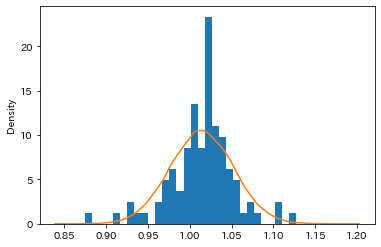

In [6]:
#正規分布を推定
loc_s, scale_s = norm.fit(df2['SandP(前月比率)'].dropna())
print('平均:{},標準偏差：{}'.format(loc_s, scale_s))

sample = np.random.normal(loc_s, scale_s, 100000)

plt.hist(df2['SandP(前月比率)'],bins=30,density=True)
sns.kdeplot(sample)
plt.show()

平均:1.0117086807017828,標準偏差：0.04624567480781826


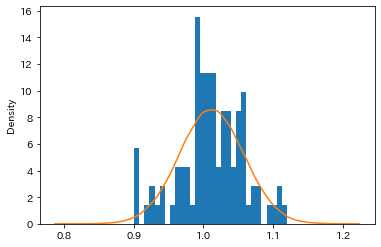

In [7]:
#正規分布を推定
loc_t, scale_t = norm.fit(df2['TOPIX(前月比率)'].dropna())
print('平均:{},標準偏差：{}'.format(loc_t, scale_t))

sample = np.random.normal(loc_t, scale_t, 100000)

plt.hist(df2['TOPIX(前月比率)'],bins=30,density=True)
sns.kdeplot(sample)
plt.show()

# ポートフォリオのリスク、リターン計算関数を作成

In [8]:
def estimate_return(loc1,loc2,x1,x2):
    return loc1*x1+loc2*x2
    
def estimate_risk(scale1,scale2,x1,x2,rho):
    cov=rho*scale1*scale2*x1*x2
    var=2*cov+(scale1*x1)**2+(scale2*x2)**2
    return np.sqrt(var)

In [9]:
estimate_return(loc_s,loc_t,0.5,0.5)

1.0129227191720402

In [10]:
estimate_risk(scale_s,scale_t,0.5,0.5,rho)

0.037325357852331605

### 結果を格納するデータフレームを作成

In [11]:
df_result=pd.DataFrame()
df_result["SandP"]=np.linspace(0,1,101)
df_result["TOPIX"]=1-df_result["SandP"]
df_result

,SandP,TOPIX
0,0.00,1.00
1,0.01,0.99
2,0.02,0.98
3,0.03,0.97
4,0.04,0.96
...,...,...
96,0.96,0.04
97,0.97,0.03
98,0.98,0.02
99,0.99,0.01


### 計算

In [12]:
df_result['return']=0
df_result['sigma']=0
for i in range(len(df_result)):
    x1=df_result.iloc[i,0]
    x2=df_result.iloc[i,1]
    df_result.loc[i,"return"]=estimate_return(loc_s,loc_t,x1,x2)
    df_result.loc[i,"sigma"]=estimate_risk(scale_s,scale_t,x1,x2,rho)
df_result

,SandP,TOPIX,return,sigma
0,0.00,1.00,1.011709,0.046246
1,0.01,0.99,1.011733,0.045999
2,0.02,0.98,1.011757,0.045754
3,0.03,0.97,1.011782,0.045511
4,0.04,0.96,1.011806,0.045270
...,...,...,...,...
96,0.96,0.04,1.014040,0.037659
97,0.97,0.03,1.014064,0.037766
98,0.98,0.02,1.014088,0.037878
99,0.99,0.01,1.014112,0.037993


### 可視化

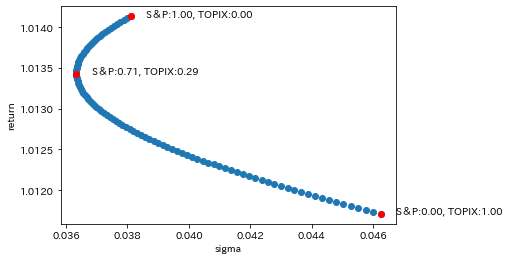

In [13]:
import matplotlib.pyplot as plt
plt.scatter(df_result['sigma'],df_result['return'])

temp=df_result.sort_values(by='sigma').iloc[0,:]
plt.scatter(temp['sigma'],temp['return'],c='r')
plt.text(temp['sigma']+0.0005,temp['return'],'S＆P:{:.2f}, TOPIX:{:.2f}'.format(temp['SandP'],temp['TOPIX']))

temp=df_result.iloc[0,:]
plt.scatter(temp['sigma'],temp['return'],c='r')
plt.text(temp['sigma']+0.0005,temp['return'],'S＆P:{:.2f}, TOPIX:{:.2f}'.format(temp['SandP'],temp['TOPIX']))

temp=df_result.iloc[-1,:]
plt.scatter(temp['sigma'],temp['return'],c='r')
plt.text(temp['sigma']+0.0005,temp['return'],'S＆P:{:.2f}, TOPIX:{:.2f}'.format(temp['SandP'],temp['TOPIX']))
plt.xlabel('sigma')
plt.ylabel('return')
plt.show()

- TOPIXの方がリターンが小さく、リスクが大きいが、最もリスクを小さくしたければ、TOPIXが29%必要なことがわかる
